# Project 2: Covid ---> III/ Models and predictions

The purpose of this file is to test and compare several models on the matrix extracted from the "II_features-selection" file (training on data from Europe only). Then we will improve the best model and analyse it. Finally, we will apply this model to other continents.

In [32]:
# Import
%matplotlib inline

import os
import os.path as op
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, auc

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Literature

In 2019, the first COVID-19 cases are observed in China. Rapidly, the SARS-Cov2 virus spread worldwide, pushing governments to take strict decisions about the lives of their co-citizens, like containment, to protect the population. Indeed, in some cases, COVID-19 patients ended up in intensive care services and sometimes died.

**The aim of our model is, based on easily computable parameters at the study's beginning, to predict whether the patient will be likely to die or if the chance of survival is important.** The point of this study is to help the hospital organise in the case of a high number of cases.


The studied dataset stem from the IDDO Data Repository of COVID-19 data. This data was pulled from the underlying data collection projects on 2022-09-01. The data comes from 1,200 institutions from over 45 countries and gather various information from 700,000 hospitalised individuals.

To keep only the relevant features, we first dive into the literature, using Meta-analysis papers. First, we have been looking for aggravating factors that will likely lead the patient to ICU.

Obesity: according to a meta-analysis by Sales-Peres, there is a correlation between obesity and ICU admission. This paper also concluded that co-morbidities for obese patients, such as hypertension, type 2 diabetes, smoking habit, lung disease, and/or cardiovascular disease lead to a higher chance of ICU admission.
Age: patients aged 70 years and above have a higher risk of infection and a higher need for intensive care than patients younger than 70.
Sex: men, when infected, have a higher risk of severe COVID-19 disease and a higher need for intensive care than women\cite{pijls_demographic_2021}.
Ethnicity: the risk of contamination was higher in most ethnic minority groups than their White counterparts in North America and Europe. Among people with confirmed infection, African-Americans and Hispanic Americans were also more likely than White Americans to be hospitalised with SARS-CoV-2 infection. However, the probability of ICU admission was equivalent for all groups. Thus, ethnicity is not relevant to our question. 
Blood tests: Patients with increased pancreatic enzymes, including elevated serum lipase or amylase of either type, had worse clinical outcomes. Lower levels of lymphocytes and hemoglobin; elevated levels of leukocytes, aspartate aminotransferase, alanine aminotransferase, blood creatinine, blood urea nitrogen, high-sensitivity troponin, creatine kinase, high-sensitivity C-reactive protein, interleukin 6, D-dimer, ferritin, lactate dehydrogenase, and procalcitonin; and a high erythrocyte sedimentation rate were also associated with severe COVID-19.  

Out of a total of 3009 citations, 17 articles (22 studies, 21 from China and one study from Singapore) with 3396 ranging from 12 to1099 patients were included. Our meta-analyses showed a significant decrease in lymphocyte, monocyte, and eosinophil, hemoglobin, platelet, albumin, serum sodium, lymphocyte to C-reactive protein ratio (LCR), leukocyte to C-reactive protein ratio (LeCR), leukocyte to IL-6 ratio (LeIR), and an increase in the neutrophil, alanine aminotransferase (ALT), aspartate aminotransferase (AST), total bilirubin, blood urea nitrogen (BUN), creatinine (Cr), erythrocyte Sedimentation Rate (ESR), C-reactive protein (CRP), Procalcitonin (PCT), lactate dehydrogenase (LDH), fibrinogen, prothrombin time (PT), D-dimer, glucose level, and neutrophil to lymphocyte ratio (NLR) in the severe group compared with the non-severe group. 

No significant changes in white blood cells (WBC), Creatine Kinase (CK), troponin I, myoglobin, IL-6 and K between the two groups were observed. 

## 2. Load data after data_selection and feature_selection

The file we open already has: 
- lines with NA for DSDECOD that have been removed
- the NAs that have been filled in 
- the standardisation that has been performed 
- the features we want to keep that have been selected
- the data has been stratified over the continents, and we only kept the data from Europe

**WARNING: These are only the data for Europe because we want to do the training only on Europe.**

In [2]:
# Open file
data_folder = op.join(os.getcwd(), "data", "results")
mylist = []
for chunk in pd.read_csv(op.join(data_folder, 'df_final_II-FeaturesSelection_train_LogisticRegression_alldata.csv'), sep=',', low_memory=False, chunksize=5000, index_col=0):
    mylist.append(chunk)
df_train = pd.concat(mylist, axis=0)
df_train.name = 'df_train'
del mylist

In [3]:
data_folder = op.join(os.getcwd(), "data", "results")
mylist = []
for chunk in pd.read_csv(op.join(data_folder, 'df_final_II-FeaturesSelection_test_LogisticRegression_alldata.csv'), sep=',', low_memory=False, chunksize=5000, index_col=0):
    mylist.append(chunk)
df_test = pd.concat(mylist, axis=0)
df_test.name = 'df_test'
del mylist

In [4]:
df_train.head(3)

,SEX,IETEST_Cough,IETEST_Fever,INCLAS_VACCINES,AGE,LBTEST_APTT,LBTEST_BILI,LBTEST_CRP,LBTEST_GLUC,LBTEST_HCT,...,LBTEST_LDH,LBTEST_SODIUM,LBTEST_UREAN,VSTEST_DIABP,VSTEST_HR,VSTEST_MAP,VSTEST_OXYSAT,VSTEST_RESP,VSTEST_SYSBP,DSDECOD
0,0.0,0.0,0.0,0.0,0.709161,-0.083546,-0.155528,-0.225248,-0.103501,0.001635,...,-0.086105,-0.031763,-0.235018,-0.268879,-0.541073,-0.026031,0.000606,-0.930559,-0.286771,1.0
1,0.0,1.0,1.0,0.0,-2.127947,-0.083546,-0.155528,-0.225248,0.701866,0.001635,...,-0.472977,-0.031763,-0.585141,-0.332212,0.568828,0.707501,0.000606,-0.403798,-0.098491,0.0
2,1.0,1.0,1.0,0.0,-0.341620,-0.083546,-0.338341,1.319953,-0.257198,0.001635,...,2.033032,-0.687310,-0.723068,-0.268879,0.297519,-0.026031,0.002965,-0.667179,-0.550364,0.0


In [5]:
df_train.shape

(78912, 21)

In [6]:
df_train.columns

Index(['SEX', 'IETEST_Cough', 'IETEST_Fever', 'INCLAS_VACCINES', 'AGE',
       'LBTEST_APTT', 'LBTEST_BILI', 'LBTEST_CRP', 'LBTEST_GLUC', 'LBTEST_HCT',
       'LBTEST_INR', 'LBTEST_LDH', 'LBTEST_SODIUM', 'LBTEST_UREAN',
       'VSTEST_DIABP', 'VSTEST_HR', 'VSTEST_MAP', 'VSTEST_OXYSAT',
       'VSTEST_RESP', 'VSTEST_SYSBP', 'DSDECOD'],
      dtype='object')

In [11]:
# Import data for other continents

df_Asia_self = pd.read_csv(op.join(data_folder, 'df_Asia_SelfStd.csv'), sep=',', index_col=0)
df_Asia_NonSelf = pd.read_csv(op.join(data_folder, 'df_Asia_NonSelfStd.csv'), sep=',', index_col=0)

df_SouthAmerica_self = pd.read_csv(op.join(data_folder, 'df_SouthAmerica_SelfStd.csv'), sep=',', index_col=0)
df_SouthAmerica__NonSelf = pd.read_csv(op.join(data_folder, 'df_SouthAmerica_NonSelfStd.csv'), sep=',', index_col=0)

df_NorthAmerica_self = pd.read_csv(op.join(data_folder, 'df_NorthAmerica_SelfStd.csv'), sep=',', index_col=0)
df_NorthAmerica_NonSelf = pd.read_csv(op.join(data_folder, 'df_NorthAmerica_NonSelfStd.csv'), sep=',', index_col=0)

dfs_continents = [df_Asia_self, df_Asia_NonSelf, df_SouthAmerica_self, df_SouthAmerica__NonSelf, df_NorthAmerica_self, df_NorthAmerica_NonSelf]
list_continents = ['Asia_self', 'Asia_NonSelf', 'SouthAmerica_self', 'SouthAmerica__NonSelf', 'NorthAmerica_self', 'NorthAmerica_NonSelf']

## 3.Models

We try to find the best algorithm/model with the best parameters based on Europe data. We will also test if the model perform well or not on other continents.

In [12]:
# Separate data into features and label
X_train = df_train.loc[:, df_train.columns!='DSDECOD']
y_train = df_train['DSDECOD']

X_test = df_test.loc[:, df_test.columns!='DSDECOD']
y_test = df_test['DSDECOD']

In [13]:
# Function to calculate performances

def performance(df_results, model_name, data_name, y_test, y_pred, y_score, print_):
    
    # Calculate performance scores
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    # Print performance
    if print_ == True:
        print('Performance for ' + model_name + ':')
        print('  - Accuracy score = {:.2f}'.format(accuracy))
        print('  - F1 score = {:.2f}'.format(f1))
        print('  - Precision score = {:.2f}'.format(precision))
        print('  - Recall score = {:.2f}'.format(recall))
        print('  - ROC AUC score = {:.2f}'.format(roc_auc))
        print('  - Average precision score = {:.2f}'.format(average_precision))

    # Add performance to df_results_performance
    df_results = df_results.append(pd.Series({"Model" : model_name,
                                              "Data" : data_name,
                                              "Parameters": parameters,
                                              "Accuracy" : accuracy,
                                              "F1" : f1,
                                              "Precision": precision,
                                              "Recall" : recall,
                                              "ROC AUC" : roc_auc,
                                              "Average precision" : average_precision}), ignore_index=True)
    return df_results

In [14]:
# Function to apply model to other continents and calculate performances

def other_continents(dfs_continents, list_continents, clf, df_results_OtherContinents, model_name):
    
    for i, dfi in enumerate(dfs_continents):
    
        name_continent = list_continents[i]
    
        # Separate in X and y
        X_continent = dfi.loc[:, dfi.columns!='DSDECOD']
        y_continent = dfi['DSDECOD']
    
        # Predicting values
        y_pred_continent = clf.predict(X_continent)

        # Proba for the greater label
        y_score_continent = clf.predict_proba(X_continent)[:, 1]
    
        # Calculate performance scores
        df_results_OtherContinents = performance(df_results_OtherContinents, model_name, name_continent, y_continent, y_pred_continent, y_score_continent, False)

    return df_results_OtherContinents

In [15]:
# For storage of results for each model
df_results_performance = pd.DataFrame()
df_results_coeff = pd.DataFrame(X_train.columns, columns=['Features'])
df_results_OtherContinents = pd.DataFrame()

### 3.1. Model 1: Logistic regression

In [17]:
%%time
# Choose parameter values to test for cross-validation
param_grid = {"C":np.logspace(-3,3,4), 
              "penalty":["l2"]}

# Choose the estimator
estimator = LogisticRegression(max_iter=200)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'C':best_param['C'], 'penalty':best_param['penalty']}
print('Best parameters for Logistic regression:')
print('C:', parameters['C'])
print('Penalty:', parameters['penalty'])
print('------------')

# Calculate performance on Europe test
df_results_performance = performance(df_results_performance, "Logistic Regression", "Europe test", y_test, y_pred, y_score, True)

# Look at coefs
coefs = clf.best_estimator_.coef_
df_results_coeff["Logistic Regression"] = coefs[0]

# Calculate performance on other continents
df_results_OtherContinents = other_continents(dfs_continents, list_continents, clf, df_results_OtherContinents, "Logistic Regression")

Best parameters for Logistic regression:
C: 1000.0
Penalty: l2
------------
Performance for Logistic Regression:
  - Accuracy score = 0.70
  - F1 score = 0.60
  - Precision score = 0.50
  - Recall score = 0.74
  - ROC AUC score = 0.79
  - Average precision score = 0.59
CPU times: total: 1.48 s
Wall time: 1.51 s


C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

### 3.2. Model 2 : K-Nearest Neighbor Classifier

In [18]:
%%time
# Choose parameter values to test for cross-validation
k_range = list(range(5, 21, 5))
param_grid = dict(n_neighbors=k_range)

# Choose the estimator
estimator = KNeighborsClassifier()

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'k':best_param['n_neighbors']}
print('Best parameters for K-Nearest Neighbor:')
print('k:', parameters['k'])
print('------------')

# Calculate performance on Europe test
df_results_performance = performance(df_results_performance, "K-Nearest Neighbor", "Europe test", y_test, y_pred, y_score, True)

# Look at coefs
df_results_coeff["K-Nearest Neighbor"] = "-"

# Calculate performance on other continents
df_results_OtherContinents = other_continents(dfs_continents, list_continents, clf, df_results_OtherContinents, "K-Nearest Neighbor")

C:\Users\sande\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sande\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Best parameters for K-Nearest Neighbor:
k: 5
------------
Performance for K-Nearest Neighbor:
  - Accuracy score = 0.67
  - F1 score = 0.55
  - Precision score = 0.46
  - Recall score = 0.67
  - ROC AUC score = 0.73
  - Average precision score = 0.47


C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

CPU times: total: 18min 24s
Wall time: 7min 2s


C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,


### 3.3. Model 3 : Support Vector Machines

In [19]:
# Because svm is too long, we will take a sample
X_train_svm = X_train.sample(n=10000)
y_train_svm = y_train.sample(n=10000)

In [20]:
%%time

# Choose parameter values to test for cross-validation
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear']} 

# Choose the estimator
estimator = svm.SVC(probability=True)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True), verbose=True)

# Fit data into the model
clf.fit(X_train_svm, y_train_svm)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'C':best_param['C'], 'gamma':best_param['gamma'], 'kernel':best_param['kernel']}
print('Best parameters for SVM:')
print('C:', parameters['C'])
print('gamma:', parameters['gamma'])
print('kernel:', parameters['kernel'])
print('------------')

# Calculate performance on Europe test
df_results_performance = performance(df_results_performance, "SVM", "Europe test", y_test, y_pred, y_score, True)

# Look at coefs
coefs = clf.best_estimator_.coef_
df_results_coeff["SVM"] = coefs[0]

# Calculate performance on other continents
df_results_OtherContinents = other_continents(dfs_continents, list_continents, clf, df_results_OtherContinents, "SVM")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for SVM:
C: 1
gamma: 1
kernel: linear
------------
Performance for SVM:
  - Accuracy score = 0.51
  - F1 score = 0.37
  - Precision score = 0.30
  - Recall score = 0.48
  - ROC AUC score = 0.52
  - Average precision score = 0.30


C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

CPU times: total: 40min 42s
Wall time: 40min 42s


C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,


In [21]:
df_results_performance

,Model,Data,Parameters,Accuracy,F1,Precision,Recall,ROC AUC,Average precision
0,Logistic Regression,Europe test,"{'C': 1000.0, 'penalty': 'l2'}",0.702990,0.595337,0.496875,0.742465,0.792162,0.593163
1,K-Nearest Neighbor,Europe test,{'k': 5},0.670428,0.545350,0.459002,0.671714,0.726428,0.466445
2,SVM,Europe test,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0.514365,0.367893,0.298138,0.480260,0.522272,0.302824


In [22]:
coefs

array([[-0.05761004, -0.31287207, -1.21622298, -1.46293349,  0.02236104,
        -0.00941147,  0.02383403,  0.00445655, -0.0249365 , -0.32452762,
        -0.05684458,  0.03686191, -0.04817381, -0.03864626, -0.06173494,
        -0.03165302,  0.04588634,  1.17376378,  0.02905442,  0.00442297]])

### 3.4. Model 4 : Multi-layer perceptrons

In [23]:
%%time
# Choose parameter values to test for cross-validation
param_grid = {'hidden_layer_sizes': np.arange(10, 50, 3),
              'activation': ['relu', 'logistic'],
              'solver': ['sgd', 'adam'],
              'learning_rate': ['adaptive'],
              'learning_rate_init': [0.01, 0.001]}

# Choose the estimator
estimator = MLPClassifier(max_iter=300)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'hidden_layer_sizes':best_param['hidden_layer_sizes'], 'activation':best_param['activation'], 
              'solver':best_param['solver'], 'learning_rate':best_param['learning_rate'], 'learning_rate_init':best_param['learning_rate_init'], }
print('Best parameters for MLP:')
print('hidden_layer_sizes:', parameters['hidden_layer_sizes'])
print('activation:', parameters['activation'])
print('solver:', parameters['solver'])
print('learning_rate:', parameters['learning_rate'])
print('learning_rate_init:', parameters['learning_rate_init'])
print('------------')

# Calculate performance on Europe test
df_results_performance = performance(df_results_performance, "MLP", "Europe test", y_test, y_pred, y_score, True)

# Look at coefs
df_results_coeff["MLP"] = "-"

# Calculate performance on other continents
df_results_OtherContinents = other_continents(dfs_continents, list_continents, clf, df_results_OtherContinents, "MLP")

C:\Users\sande\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sande\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sande\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sande\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sande\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Best parameters for MLP:
hidden_layer_sizes: 40
activation: relu
solver: adam
learning_rate: adaptive
learning_rate_init: 0.01
------------
Performance for MLP:
  - Accuracy score = 0.71
  - F1 score = 0.60
  - Precision score = 0.50
  - Recall score = 0.75
  - ROC AUC score = 0.80
  - Average precision score = 0.61
CPU times: total: 11h 40min 2s
Wall time: 1h 27min 33s


C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

### 3.5. Model 5 : Quadratic discriminant analysis

In [24]:
%%time
# Choose parameter values to test for cross-validation
param_grid = [{'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}]

# Choose the estimator
estimator = QuadraticDiscriminantAnalysis()

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'reg_param':best_param['reg_param']}
print('Best parameters for Quadratic discriminant analysis:')
print('reg_param:', parameters['reg_param'])
print('------------')

# Calculate performance on Europe test
df_results_performance = performance(df_results_performance, "Quadratic discriminant analysis", "Europe test", y_test, y_pred, y_score, True)

# Look at coefs
df_results_coeff["Quadratic discriminant analysis"] = "-"

# Calculate performance on other continents
df_results_OtherContinents = other_continents(dfs_continents, list_continents, clf, df_results_OtherContinents, "Quadratic discriminant analysis")

Best parameters for Quadratic discriminant analysis:
reg_param: 0.1
------------
Performance for Quadratic discriminant analysis:
  - Accuracy score = 0.72
  - F1 score = 0.49
  - Precision score = 0.54
  - Recall score = 0.45
  - ROC AUC score = 0.76
  - Average precision score = 0.52
CPU times: total: 9.23 s
Wall time: 1.15 s


C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

### 3.6. Model 6 : XGBoost

In [25]:
%%time

# Choose parameter values to test for cross-validation
param_grid = {'max_depth': range (2, 10, 1),
              'n_estimators': range(60, 220, 40),
              'learning_rate': [0.1, 0.01, 0.05],
              'booster': ['gbtree', 'gblinear']}

# Choose the estimator
estimator = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'max_depth':best_param['max_depth'], 'n_estimators':best_param['n_estimators'], 'learning_rate':best_param['learning_rate'], 'booster':best_param['booster']}
print('Best parameters for XGBoost:')
print('max_depth:', parameters['max_depth'])
print('n_estimators:', parameters['n_estimators'])
print('learning_rate:', parameters['learning_rate'])
print('booster:', parameters['booster'])
print('------------')

# Calculate performance on Europe test
df_results_performance = performance(df_results_performance, "XGBoost", "Europe test", y_test, y_pred, y_score, True)

# Look at coefs
if (parameters['booster']=='gblinear'):
    coefs = clf.best_estimator_.coef_
    df_results_coeff["XGBoost"] = coefs
else:
    feature_importances = clf.best_estimator_.feature_importances_
    df_results_coeff["XGBoost"] = feature_importances

# Calculate performance on other continents
df_results_OtherContinents = other_continents(dfs_continents, list_continents, clf, df_results_OtherContinents, "XGBoost")

[01:50:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[01:50:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[01:50:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[01:50:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[01:50:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[01:5

C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.Series({"Model" : model_name,
C:\Users\sande\AppData\Local\Temp\ipykernel_5784\3528801577.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

### 3.7. Models comparison

In [26]:
# Performance of each model
df_results_performance.sort_values(by="F1", axis=0, ascending=False).round(2).set_index('Model')

,Data,Parameters,Accuracy,F1,Precision,Recall,ROC AUC,Average precision
Model,,,,,,,,
MLP,Europe test,"{'hidden_layer_sizes': 40, 'activation': 'relu...",0.71,0.60,0.50,0.75,0.80,0.61
Logistic Regression,Europe test,"{'C': 1000.0, 'penalty': 'l2'}",0.70,0.60,0.50,0.74,0.79,0.59
XGBoost,Europe test,"{'max_depth': 8, 'n_estimators': 180, 'learnin...",0.76,0.56,0.62,0.52,0.81,0.63
K-Nearest Neighbor,Europe test,{'k': 5},0.67,0.55,0.46,0.67,0.73,0.47
Quadratic discriminant analysis,Europe test,{'reg_param': 0.1},0.72,0.49,0.54,0.45,0.76,0.52
SVM,Europe test,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0.51,0.37,0.30,0.48,0.52,0.30


In [27]:
# Feature importance for each model
df_results_coeff.round(4).set_index('Features')

,Logistic Regression,K-Nearest Neighbor,SVM,MLP,Quadratic discriminant analysis,XGBoost
Features,,,,,,
SEX,-0.4721,-,-0.0576,-,-,0.0465
IETEST_Cough,0.1371,-,-0.3129,-,-,0.0152
IETEST_Fever,0.1405,-,-1.2162,-,-,0.0164
INCLAS_VACCINES,-1.0460,-,-1.4629,-,-,0.1055
AGE,1.2202,-,0.0224,-,-,0.1751
LBTEST_APTT,0.0851,-,-0.0094,-,-,0.0254
LBTEST_BILI,0.0956,-,0.0238,-,-,0.0355
LBTEST_CRP,0.2933,-,0.0045,-,-,0.0496
LBTEST_GLUC,0.0316,-,-0.0249,-,-,0.0293


In [28]:
# Performance on other continents
df_results_OtherContinents.sort_values(by="Data", axis=0).round(2).set_index("Data")

,Model,Parameters,Accuracy,F1,Precision,Recall,ROC AUC,Average precision
Data,,,,,,,,
Asia_NonSelf,Logistic Regression,"{'C': 1000.0, 'penalty': 'l2'}",0.90,0.04,0.13,0.02,0.89,0.35
Asia_NonSelf,XGBoost,"{'max_depth': 8, 'n_estimators': 180, 'learnin...",0.09,0.16,0.09,1.00,0.48,0.11
Asia_NonSelf,Quadratic discriminant analysis,{'reg_param': 0.1},0.20,0.17,0.10,0.99,0.56,0.10
Asia_NonSelf,K-Nearest Neighbor,{'k': 5},0.09,0.16,0.09,0.99,0.52,0.09
Asia_NonSelf,MLP,"{'hidden_layer_sizes': 40, 'activation': 'relu...",0.10,0.16,0.09,0.98,0.50,0.09
Asia_NonSelf,SVM,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0.09,0.16,0.09,0.99,0.33,0.09
Asia_self,Logistic Regression,"{'C': 1000.0, 'penalty': 'l2'}",0.77,0.39,0.25,0.84,0.88,0.49
Asia_self,XGBoost,"{'max_depth': 8, 'n_estimators': 180, 'learnin...",0.09,0.16,0.09,0.99,0.48,0.07
Asia_self,K-Nearest Neighbor,{'k': 5},0.63,0.22,0.13,0.60,0.66,0.13


In [29]:
# Reminder: percentage of death
dfs = [df_test, df_Asia_self, df_SouthAmerica_self, df_NorthAmerica_self]
continents = ["Europe_test", "Asia", "SouthAmerica", "NorthAmerica"]
for i, dfi in enumerate(dfs):
    distribution = dfi['DSDECOD'].value_counts()
    print("In", continents[i], ":", distribution[0], "survivals,", distribution[1], "deaths, so a", round(distribution[0]/(distribution[0]+distribution[1])*100, 2), "% survival rate.")

In Europe_test : 16949 survivals, 7067 deaths, so a 70.57 % survival rate.
In Asia : 5994 survivals, 561 deaths, so a 91.44 % survival rate.
In SouthAmerica : 5133 survivals, 748 deaths, so a 87.28 % survival rate.
In NorthAmerica : 4077 survivals, 1178 deaths, so a 77.58 % survival rate.


In [30]:
# Investigate features
df_results_features = pd.DataFrame(X_train.columns, columns=['Features'])
df_results_features['Survival_percent'] = [round(X_test[c].value_counts(normalize=True).values[0], 2) if (X_test[c].nunique()==2) else '-' for c in X_test.columns]
df_results_features

,Features,Survival_percent
0,SEX,0.56
1,IETEST_Cough,0.51
2,IETEST_Fever,0.53
3,INCLAS_VACCINES,0.95
4,AGE,-
5,LBTEST_APTT,-
6,LBTEST_BILI,-
7,LBTEST_CRP,-
8,LBTEST_GLUC,-
9,LBTEST_HCT,-


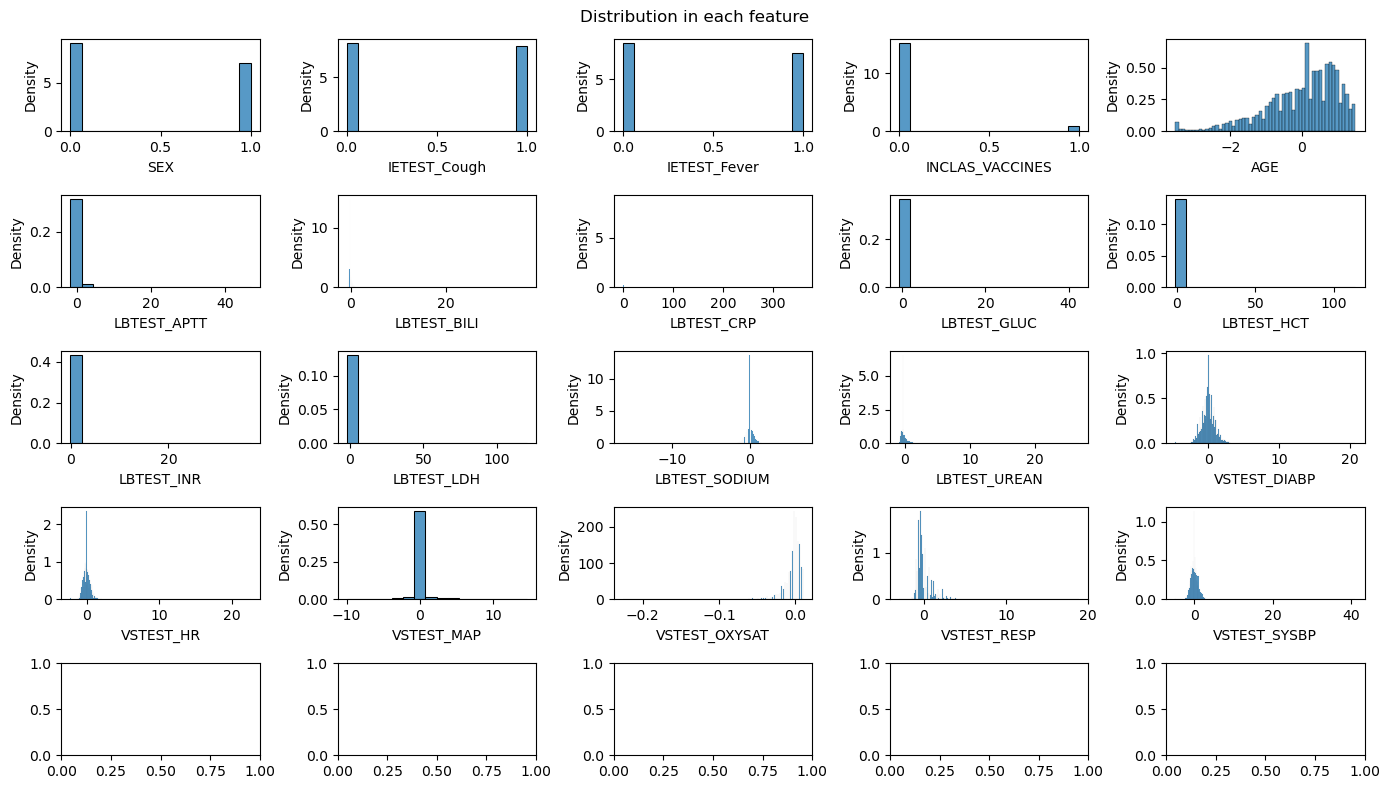

In [33]:
fig, axs = plt.subplots(5,5, figsize=(14,8))
axs = axs.flatten()

for ax, col in zip(axs, X_test.columns):
    sns.histplot(X_test[col], ax=ax, stat="density")
    
fig.suptitle("Distribution in each feature")
plt.tight_layout()
plt.show()

In [34]:
df_results_OtherContinents.sort_values(by="Data", axis=0).round(2).set_index("Data").to_csv(op.join(data_folder, "ResultsPerContinent_withINCLAS.csv"))
df_results_coeff.to_csv(op.join(data_folder, "EuropeCoeffs_withINCLAS.csv"))
df_results_performance.to_csv(op.join(data_folder, "EuropePerformances_withINCLAS.csv"))

In [35]:
df_results_OtherContinents.sort_values(by="Data", axis=0).round(2).set_index("Data").to_csv(op.join(data_folder, "ResultsPerContinent.csv"))
df_results_coeff.to_csv(op.join(data_folder, "EuropeCoeffs.csv"))
df_results_performance.to_csv(op.join(data_folder, "EuropePerformances.csv"))